In [1]:
%load_ext autoreload
%autoreload 2
from load import *
import torch
import yaml
import logging
from imp import reload
import matplotlib.pyplot as plt
from liftpose.vision_3d import world_to_camera
from tqdm import tqdm
from load import get_btch
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)
tqdm.get_lock().locks = []

# decleare data parameters
par_train = {'data_dir'       : '/data/LiftPose3D/monkey/OMS_Dataset', # Change data path here
             'out_dir'        : '/data/LiftPose3D/monkey/OMS_Dataset/out', 
             'train_subjects' : ["7", "9a", "9b", "10", "11"],
             'test_subjects'  : ["9"]}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

In [2]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

from liftpose.postprocess import load_test_results
stat_2d, stat_3d = (
    torch.load(os.path.join(par['out_dir'], "stat_2d.pth.tar")),
    torch.load(os.path.join(par['out_dir'], "stat_3d.pth.tar")),
)
test_3d_gt, test_3d_pred, _ = load_test_results(par['out_dir'], stat_2d, stat_3d)
Data, cameras = get_btch('9', par_train["data_dir"])

[main.py:388]:INFO:starting testing in path: /data/LiftPose3D/monkey/OMS_Dataset/out
[lift.py:29]:INFO:Training on the device: cuda:0
[lift.py:56]:INFO:total params: 4.27M
[lift.py:64]:INFO:loading ckpt from '/data/LiftPose3D/monkey/OMS_Dataset/out/ckpt_best.pth.tar'
[lift.py:72]:INFO:ckpt loaded (epoch: 17 | err: 0.052280173707218575)
[lift.py:106]:INFO:Saving results: /data/LiftPose3D/monkey/OMS_Dataset/out/test_results.pth.tar


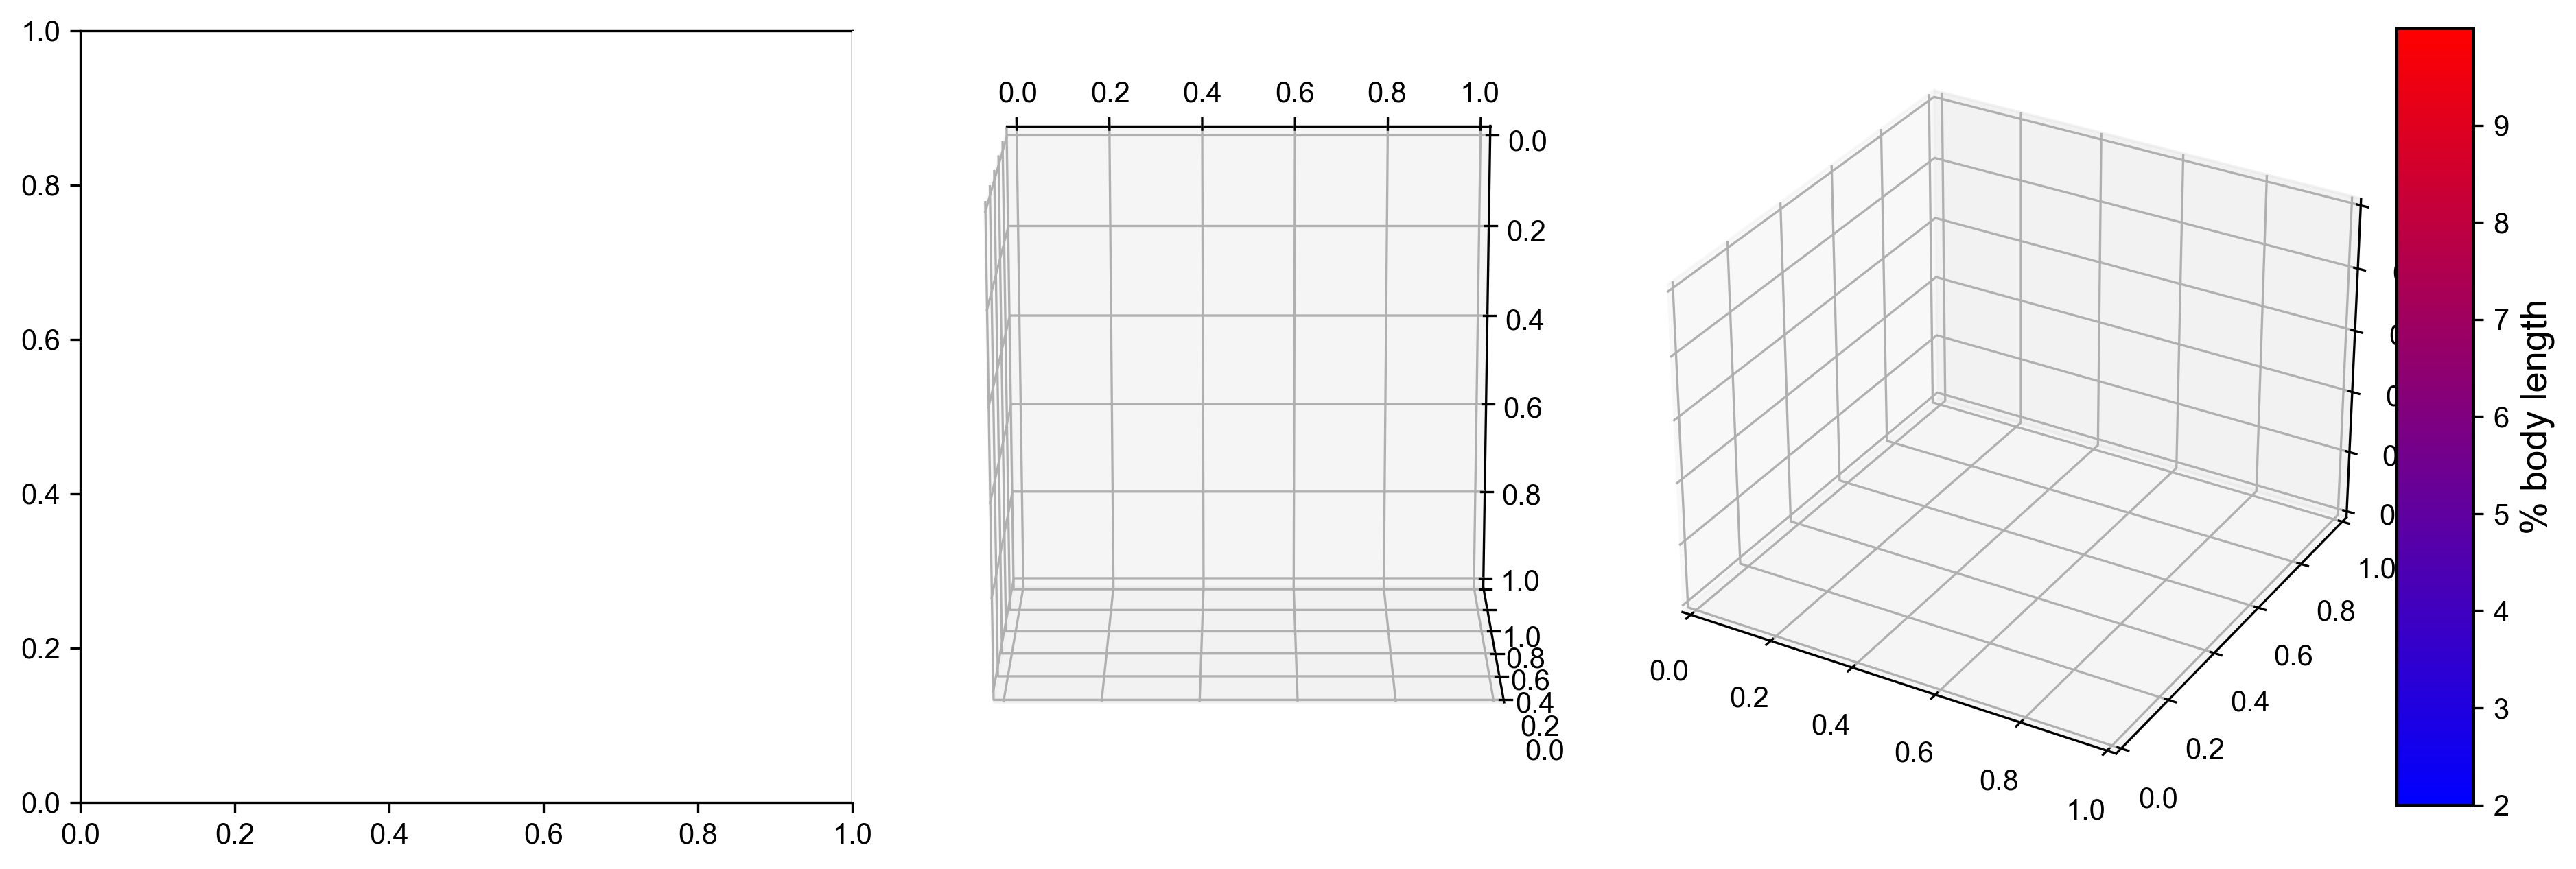

In [10]:
mpl.pyplot.rcParams["font.family"] = ['Arial']
mpl.rcParams.update({'font.size': 10})
np.random.seed(1234567)

out_path = par_train["out_dir"]
fig = plt.figure(figsize=(15,5), dpi=300)
plt.subplots_adjust(wspace=0, hspace=0)
gs1 = fig.add_gridspec(nrows=1, ncols=31)
ax2d = fig.add_subplot(gs1[:, :10])
ax3d = fig.add_subplot(gs1[:, 10:20], projection='3d')
ax3d_cameras = fig.add_subplot(gs1[:, 20:30], projection='3d')
ax_bar = fig.add_subplot(gs1[:, -1])
for i in range(50):
    idx = np.random.randint(test_3d_pred.shape[0])
    k = list(Data.keys())[idx]

    btch, img_id, cam = k
    img_name = os.path.join(par['data_dir'], 'Images', 'batch' + str(btch) + '_' + str(img_id).zfill(9) + '_' + str(cam) + '.jpg')
    ax2d.imshow(plt.imread(img_name))
    ax2d.text(x=5, y=15, s=f"{img_id}")

    ax3d.view_init(elev=-75, azim=-90)
    plot_pose_3d(ax=ax3d,
                 bones=par_data["vis"]["bones"], 
                 pred=test_3d_pred[idx],
                 tar=test_3d_gt[idx],
                 limb_id=par_data["vis"]["limb_id"], 
                 colors=par_data["vis"]["colors"], 
                 normalize=True,
                 legend=True)

    mi, ma = 2 / 100 * 2.2, 10 / 100 * 2.2
    err = err_for_frame(Data, cameras, img_id, test_3d_gt, test_3d_pred)
    plot_cameras_err(ax=ax3d_cameras, err=err, mi=mi, ma=ma, cameras=cameras, curr_camera=cam)

    ax2d.axis('off')
    lim = [-0.75, 0.75]
    ax3d.set_xlim(lim)
    ax3d.set_ylim(lim)
    ax3d.set_zlim(lim)
    # remove ticks
    ax3d.xaxis.set_major_formatter(NullFormatter())
    ax3d.yaxis.set_major_formatter(NullFormatter())
    ax3d.zaxis.set_major_formatter(NullFormatter())
    ax3d_cameras.xaxis.set_major_formatter(NullFormatter())
    ax3d_cameras.yaxis.set_major_formatter(NullFormatter())
    ax3d_cameras.zaxis.set_major_formatter(NullFormatter())

    # setting titles
    ax3d_cameras.set_title('Lifting error per camera')
    cmap = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","r"])
    norm = mpl.colors.Normalize(vmin=mi/2.2 * 100, vmax=ma/2.2 * 100)
    cb1 = mpl.colorbar.ColorbarBase(ax_bar, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical',  ticks=np.arange(2, 10))
    cb1.set_label('Body length (%)',fontsize=13)
    
    p1 = ax3d_cameras.scatter(0,0,0, color=(0,1,0))
    ax3d_cameras.legend([(p1)],
        ["Current camera"],
        numpoints=1,
        loc=(0.0, 0.9),
        frameon=False,
        )
    p1.remove()
    
    plt.savefig(os.path.join(out_path, 'img{:03d}.jpg'.format(i)))
    ax3d_cameras.clear()
    ax3d.clear()
    ax2d.clear()

In [12]:
# add flag -vb 20M for high quality
!ffmpeg -framerate 1 -i /data/LiftPose3D/monkey/OMS_Dataset/out/img%03d.jpg monkey_video.mp4 -y

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib